In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm import tqdm
import gillespie

## Setup starting states and reactions parameters

The parameters are taken from the following paper:

>[Bacterial Persistence: A Model of Survival in Changing Environments](https://academic.oup.com/genetics/article-abstract/169/4/1807/6059501)

In [3]:
# number of molecules (individuals), in the order:
# wt, wt_persister, mut, persister
reag_quant = [50_000, 0, 50_000, 0]

# Vector updates. In the order:
# growth wt
# growth wt persister
# switch wt to wt persister
# switch wt persister to wt
# growth mut
# growth mut persister
# switch mut to mut persister
# switch mut persister to mut
state_change_vect_normal = [[+1, 0, 0, 0],
                            [0, +1, 0, 0],
                            [-1, +1, 0, 0],
                            [+1, -1, 0, 0],
                            [0, 0, +1, 0],
                            [0, 0, 0, +1],
                            [0, 0, -1, +1],
                            [0, 0, +1, -1]]

state_change_vect_abt = [[-1, 0, 0, 0],
                         [0, -1, 0, 0],
                         [-1, +1, 0, 0],
                         [+1, -1, 0, 0],
                         [0, 0, -1, 0],
                         [0, 0, 0, -1],
                         [0, 0, -1, +1],
                         [0, 0, +1, -1]]


# combinatorics functions (KEEP THIS POSITIVE, DO NOT INTRODUCE MINUS (-))
combinatorics_normal = [lambda a,b,c,d : (2 * a),
                        lambda a,b,c,d : (0.002 * b),
                        lambda a,b,c,d : ((1.2*1e-6)*a),
                        lambda a,b,c,d : (0.1*b),
                        lambda a,b,c,d : (2 * c),
                        lambda a,b,c,d : (0.2 * d),
                        lambda a,b,c,d : (0.001 * c),
                        lambda a,b,c,d : (1e-4 * d)]

combinatorics_abt = [lambda a,b,c,d : (4 * a),
                     lambda a,b,c,d : (0.4 * b),
                     lambda a,b,c,d : ((1.2*1e-6)*a),
                     lambda a,b,c,d : (0.1*b),
                     lambda a,b,c,d : (4 * c),
                     lambda a,b,c,d : (0.4 * d),
                     lambda a,b,c,d : (0.001 * c),
                     lambda a,b,c,d : (1e-4 * d)]


## Dict to be passed to our class

combinatorics = {'normal': combinatorics_normal,
                 'abt' : combinatorics_abt}

oscillation_interval = {'normal' : 7,
                        'abt': 2.5}

state_change_vect = {'normal': state_change_vect_normal,
                     'abt': state_change_vect_abt}

## instantiate and run class with appropriate arguments

In [4]:
%%time
a = gillespie.gillespie_dynamic.gillespie_dynamic(reagent_quantity=reag_quant, 
                                                  state_change_vectors=state_change_vect,
                                                  combinatorics=combinatorics,
                                                  max_time= 25,
                                                  # max_iteration = 1000,
                                                  rescale=110_000,
                                                  Ni=100_000,
                                                  oscillation_interval = oscillation_interval,
                                                  stop_condition="time",
                                                  start_with='normal')

# result_dict[epoch] = [a.timestep_list, a.molecular_species_history]
# plt.plot(range(a.actual_iteration+1),[y[0] for y in a.molecular_species_history])
# plt.plot([x for x in a.timestep_list],[y[0] for y in a.molecular_species_history])

Actual state is: normal, actual iteration is: 0, simulation time is 0, real time is: Fri Jan  9 12:42:30 2026.
Actual state is: normal, actual iteration is: 1000000, simulation time is 4.761161219902659, real time is: Fri Jan  9 12:42:57 2026.
7.00000269793914
2.515043176920752
Actual state is: normal, actual iteration is: 2000000, simulation time is 15.626285636993106, real time is: Fri Jan  9 12:43:25 2026.
7.000008212869851
2.5597996256534485


In [15]:
# # segment to track switches
# where_pos = []
# for tim in tqdm(a.timestep_list):
#     start_bool = tim > np.array(a.time_tracker['normal']['start'])
#     end_bool = tim < np.array(a.time_tracker['normal']['end'])
#     if any(start_bool == end_bool):
#         where_pos.append(True)
#     else:
#         where_pos.append(False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1248791/1248791 [00:06<00:00, 200021.04it/s]


<timed exec>:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


CPU times: user 3.24 s, sys: 113 ms, total: 3.36 s
Wall time: 3.35 s


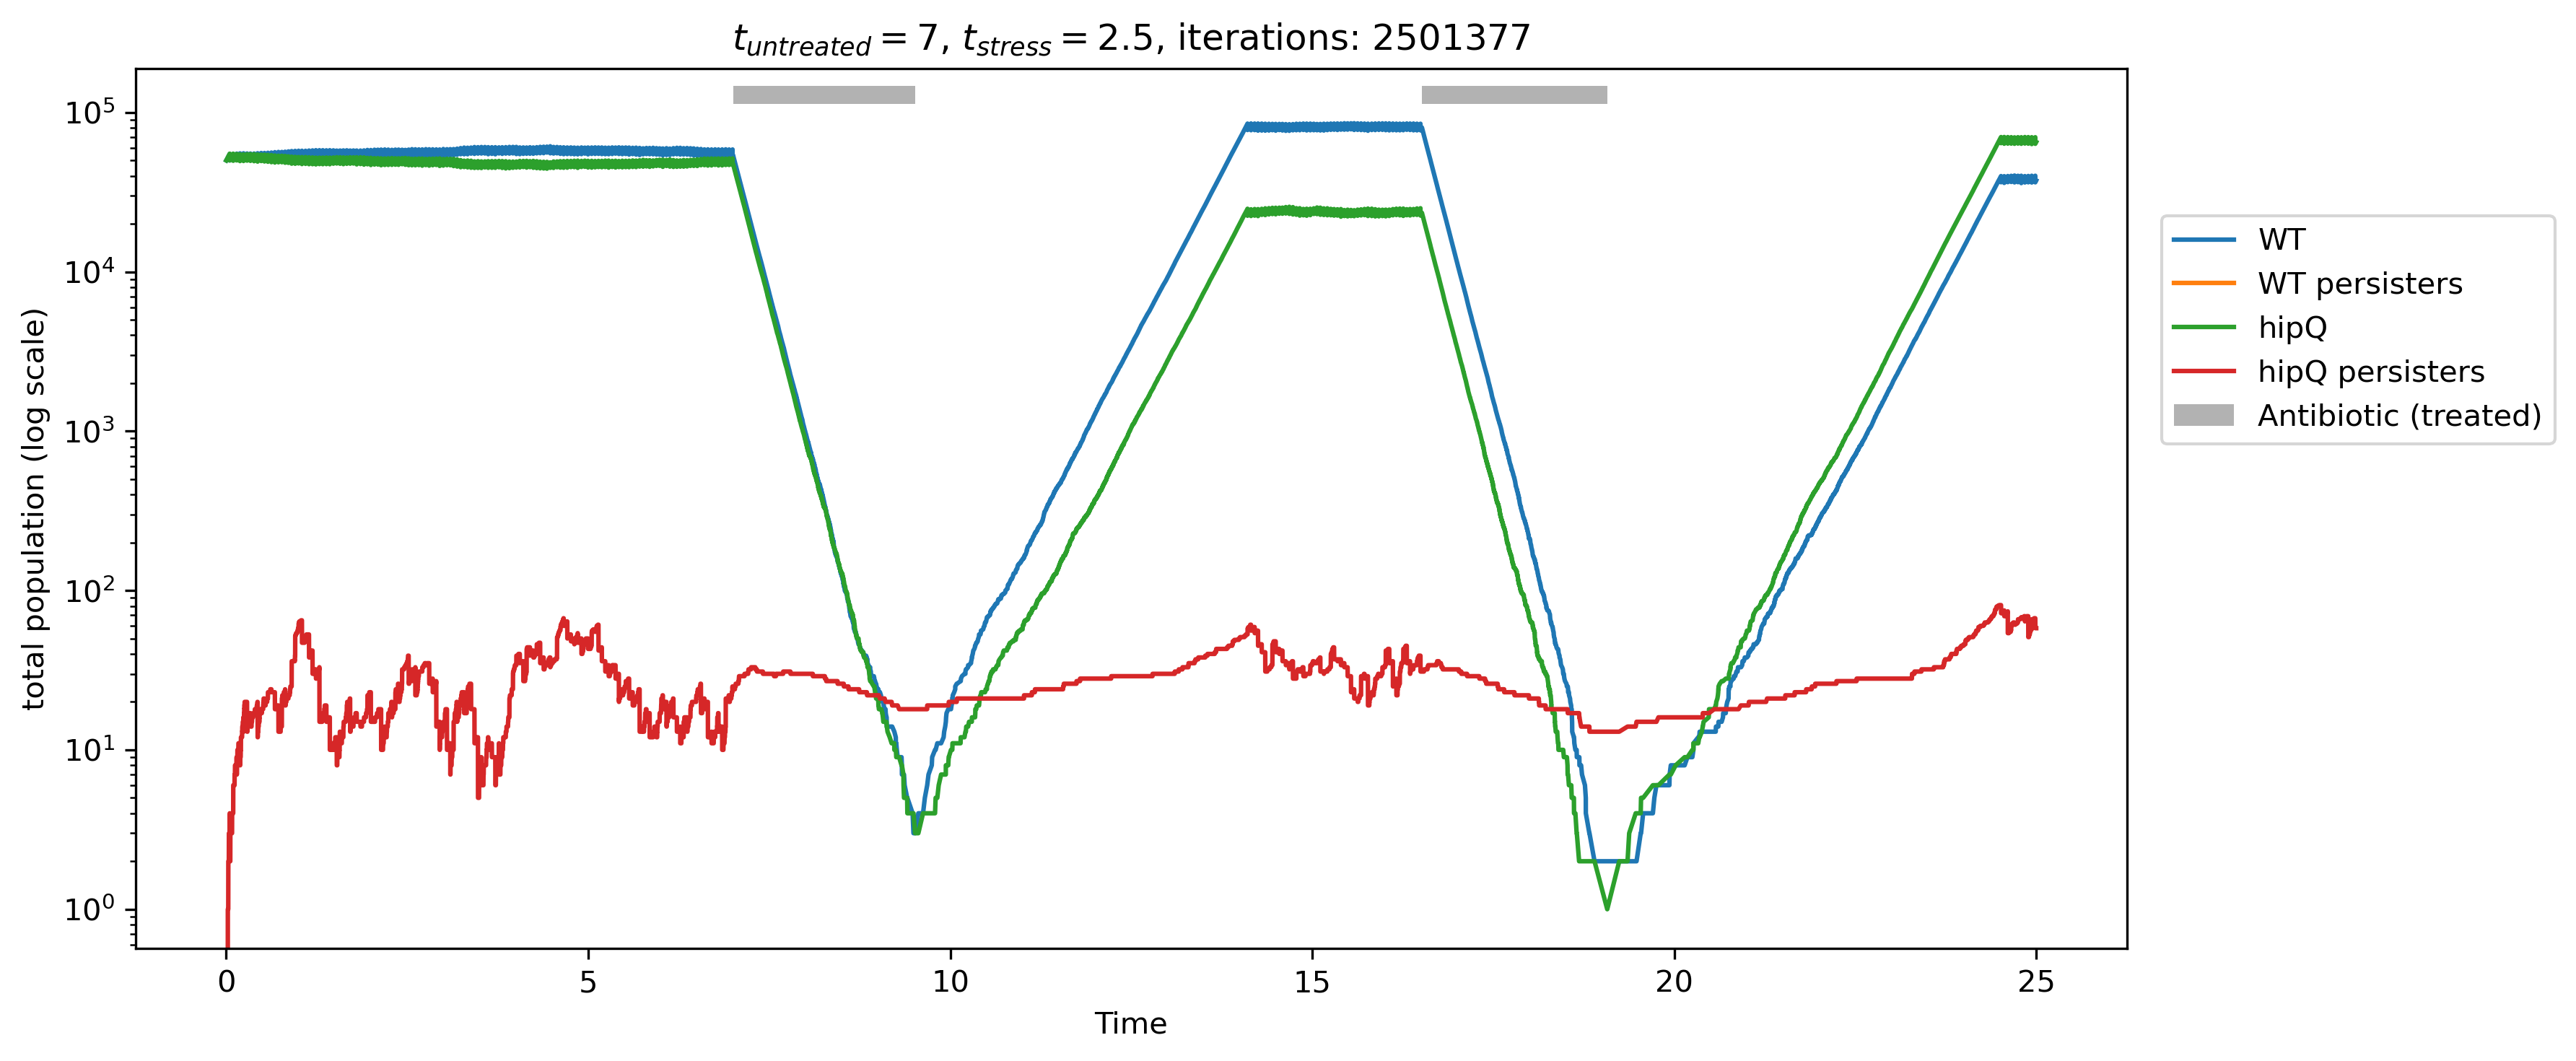

In [9]:
%%time

# out_path = ""
# img_name = "image.png"

bar_proxy = Patch(facecolor="grey", alpha=0.6, label="Antibiotic (treated)")

fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(a.timestep_list, [y[0] for y in a.molecular_species_history], label='WT')
ax.plot(a.timestep_list, [y[1] for y in a.molecular_species_history], label='WT persisters')
ax.plot(a.timestep_list, [y[2] for y in a.molecular_species_history], label='hipQ')
ax.plot(a.timestep_list, [y[3] for y in a.molecular_species_history], label='hipQ persisters')
ax.set_yscale('log')

ax.set_title(
    rf"$t_{{untreated}} = {oscillation_interval['normal']}$, "
    rf"$t_{{stress}} = {oscillation_interval['abt']}$"
    + f", iterations: {a.actual_iteration}"
)
ax.set_xlabel("Time")
ax.set_ylabel("total population (log scale)")

handles, labels = ax.get_legend_handles_labels()
handles.append(bar_proxy)
labels.append("Antibiotic (treated)")
ax.legend(handles, labels, bbox_to_anchor=(1.01, 0.85))

# collect state intervals to highlight
starts = a.time_tracker["abt"]["start"]
ends   = a.time_tracker["abt"]["end"]

# add space on top
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax * 1.25)

for s, e in zip(starts, ends):
    ax.axvspan(s, e, ymin=0.96, ymax=0.98, color="grey", alpha=0.6, lw=0)

fig.tight_layout()
# plt.savefig(os.path.join(out_path, img_name), dpi=300)